In [1]:
#make sure that all figures are labeled and clear. 

#Use Transformed and Non-Transformed Output variable when modeling

#Check residuals of prediction variable  

## Goal

The goal of this project is to predict an NFL receiver's separation at the time of pass arrival. I will be using the NFL's player-tracking data set from the last 3 seasons (2017-2019) to create these predictions

## Motivation

All receivers are NOT built equal. Receivers like Tyler Lockett (Seahawks) are short, quick, and line up in the 'Slot' often, while others like Allen Robinson (Bears) are tall, strong, and often line up out 'Wide'. Since these players have different body types, abilities, and team roles, I don't think they would have similar average receiver separations. To this end, I want to look into how much separation a receiver gains RELATIVE to their situations. 

For example, a receiver that lines up out 'Wide', is pressed at the line of scrimage, and is targeted 20 yards downfield should have little to no separation when the pass arrives. In contrast, a reciver that lines up in the slot and is targeted 3 yards behind the line of scrimmage should expect to have more separation.

When aggregated over a course of a game, season, or career, this 'expected separation' value should bring context into the players TRUE ability to separate given their in-play circumstances.



In [2]:
# Data Manipulation Modules
import pandas as pd
import numpy as np
import scipy as sp
import numpy as np
import math 
import scipy.stats as stats
import fancyimpute 
from collections import Counter

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as ms

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
LoadData = "../data/ExpSepPos.csv"

df = pd.read_csv(LoadData, index_col = False)

random_state = 1

In [4]:
print(df.shape)
print(max(df['GameId']))
print(min(df['GameId']))
df.head()

(53710, 31)
2020020200
2017090700


,GameId,PlayId,Season,Team,Receiver,Nearest_Defender,Nearest_Def_Position,Opp,Wk,Qtr,...,Air_Dist,Air_Time,TTT,Separation,QB_Separation,QBP,QB_Scramble_Yds,Receiver_Dist_From_Sideline,QB_Speed_at_Pass,EZ_Dist
0,2017102910,2814,2017,PIT,JuJu Smith-Schuster,Quandre Diggs,SS,DET,8,3,...,33.119846,1.539,2.756,1.785385,2.084347,0,4.12,26.303329,1.145455,37.540001
1,2018112509,2475,2018,PIT,JuJu Smith-Schuster,Bradley Roby,CB,DEN,12,3,...,37.510450,2.202,2.436,2.674790,1.540033,1,7.09,12.303331,3.763636,40.230003
2,2017111208,2731,2017,LA,Robert Woods,Johnathan Joseph,CB,HOU,10,3,...,52.871040,2.633,3.135,3.966674,3.386576,0,7.52,17.230000,1.247727,58.880001
3,2019120800,2777,2019,ATL,Olamide Zaccheaus,Donte Jackson,CB,CAR,14,3,...,49.233444,3.018,2.771,0.910220,2.814427,0,5.20,19.433328,1.329546,56.439999
4,2019101310,1630,2019,NYJ,Robby Anderson,Jeff Heath,SS,DAL,6,2,...,46.187710,2.636,3.003,1.676305,1.471224,1,6.58,15.103330,3.477273,57.060001


Our Dataset spans 3 years (2017-2020) and includes regular and postseason games. We have a total of 53,710 total passes with non-null receiver separations to work with. 

# Predicting Receiver Separation

## Data Cleaning

- Handle missing values
    - Discuss various ways to impute missing/null values
    - Remove Rows with missing cushion?
- Handle Outliers

## Data Exploration

- Feature Analysis
    - Numerical Features
        - Discrete Features
        - Continuous Features
    - Categorical Features
- Feature Engineering
    - Nearest Defender Position into broader groups
    
## Model Selection

- Choosing the right Model
    - Linear Regression
        - LASSO Regression
        - Ridge Regression
    - Random Fore

In [5]:
# Describing all the Numerical Features
df.describe()
COLS = df.columns.to_list()

In [6]:
# Describing all the Categorical Features
#df.describe(include=['O'])

## Dropping non-relevant features 

Right off the bat, I think a lot the variables in this dataset will not be useful in predicting reciever separation. Also, there are a lot features in this set that describe the outcome of the event. These features (Pass Yards, TD, INT) cannot be used in prediction. For features that I am skeptical of, but not sure about their effect, I will leave alone, otherwise I will drop all non-essential features below.

In [7]:
IrrelevantCols = ['GameId', 'PlayId', 'Season', 'Wk', 'Cmp', 'Team', 'Receiver', 'Nearest_Defender', 'Opp', 'Wk', 'Cmp', 'Pass Yds','TD', 'INT',
 'Comp_Prob', 'Separation', 'Time', 'QB_Scramble_Yds']

# Drop all irrelevant columns and output variable (separation)
Features = df.drop(IrrelevantCols, axis = 1)

#Create 1-dimensional array of output variable (separation)
Output = df['Separation']

#Output top 5 rows of Features Dataframe
cols = len(Features.columns)
print('We are left with ' + str(cols) + ' features to help with prediction')
Features.head()


We are left with 15 features to help with prediction


,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Dist,Air_Time,TTT,QB_Separation,QBP,Receiver_Dist_From_Sideline,QB_Speed_at_Pass,EZ_Dist
0,SS,3,3,9,Slot,3.66,24.54,33.119846,1.539,2.756,2.084347,0,26.303329,1.145455,37.540001
1,CB,3,1,10,Wide,2.66,27.23,37.510450,2.202,2.436,1.540033,1,12.303331,3.763636,40.230003
2,CB,3,2,8,Wide,10.23,42.88,52.871040,2.633,3.135,3.386576,0,17.230000,1.247727,58.880001
3,CB,3,3,8,Wide,6.74,39.44,49.233444,3.018,2.771,2.814427,0,19.433328,1.329546,56.439999
4,SS,2,1,10,Wide,3.23,39.06,46.187710,2.636,3.003,1.471224,1,15.103330,3.477273,57.060001


## Target Variable (Separation)

Let's take a look at our target variable, Reciever Separation



The Kurtosis of the distribution of the target variable is 1.7
The Skew of the distribution of the target variable is 1.2


count    53710.000000
mean         3.244240
std          2.435761
min          0.020000
25%          1.292652
50%          2.613341
75%          4.589033
max         19.226980
Name: Separation, dtype: float64

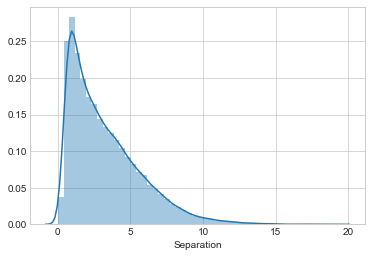

In [8]:
# How Normally Distributed is our Output Variable (Separation)

plt.style.use('seaborn-whitegrid')
Fig = sns.distplot(df['Separation'])

K = round(stats.kurtosis(df['Separation']),1)
S = round(stats.skew(df['Separation']), 1)
p_value = stats.shapiro(df['Separation'])[1]
    
print('\n')
print('The Kurtosis of the distribution of the target variable is ' + str(K))
print('The Skew of the distribution of the target variable is ' + str(S))

df['Separation'].describe()


As we can see, our data is very skewed to the right, or positively skewed, making the distribution of Separation noticably non-normal (non-gaussian). 

Based on my understanding of the game of football, the only time we would expect receiver separations to be greater than 10 yards, are in instances where the targeted player is not a current threat to gain yards (passes targeting receivers behind the line of scrimmage) OR mistakes in coverage.

## Missing Values

In [9]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
missing_values_table(Features)

Your selected dataframe has 15 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Cushion,14125,26.3
Receiver_Location,108,0.2


Of the 14125 missing cushion values, how many were from targets from receivers who lined up in the backfield?

In [10]:
Cush = df[df['Cushion'].isna()]
Cush['Receiver_Location'].value_counts()

Backfield    9846
Slot         2742
Tight        1334
Wide          114
Name: Receiver_Location, dtype: int64

In [11]:
Backfield = df[(df['Receiver_Location'] == 'Backfield')][['Cushion', 'Separation']]
print('There were ' + str(len(Backfield)) + ' plays where the player who lined up in the backfield was targeted')
print('The average Cushion of a player who lines up in the Backfield is ' + str(Backfield['Cushion'].mean()))
print('The average Separation of a player who lines up in the Backfield is ' + str(round(Backfield['Separation'].mean(), 2)))


There were 9846 plays where the player who lined up in the backfield was targeted
The average Cushion of a player who lines up in the Backfield is nan
The average Separation of a player who lines up in the Backfield is 4.77


Every target to a player that lined up in the *'Backfield'* in this dataset has a **null cushion value**. This makes sense, as they are far from the line of scrimmage, often behind, or to the side of the QB at the time of snap, and roughly 5-10 yards behind the line of scrimmage when the ball is snapped, making it nearly impossible to determine who is covering them, if anyone specific at all. 

If all of the Backfield targets are missing a cushion value, this means that this type of data is *Missing Not at Random* ([relevant wiki](https://en.wikipedia.org/wiki/Missing_data#Missing_not_at_random)). With data that is missing Not at Random, it is not 'ignorable' since removing all of these rows would drastically change the distribution of Separation values. 

That being said, the goal of this project is try to predict a players separation as accurately as possible, and if we remove just the backfield targets, we don't necessarily lose any insight in how to predict Separation for non-backfield targets. 

## Ways to deal with missing Cushion values 
 1. Impute the missing values
     - Replace missing values with a summary statistic (like a mean/median)
         - This would introduce a lot bias into the distribution of Cushion in the whole data set (25% would be one number)
     - Use something like kNN (K-nearest neighbors) or other ML model to predict Cushion 
         - 'Backfield' rows have 0 cushion values
         - We have to use other Features in the dataset to draw from
 2. Remove all rows where the receiver location is 'Backfield' 
     - This will remove ~10,000 rows, losing data is never ideal, but sometimes necessary 
     - Predicting non-backfield targets will likely be more accurate after removing these rows
     - Remember our goal: creating a way to compare receivers
         - Since RBs are the primary receiver out of the backfield, I am not as concerned about their ability to create separation

Let's take a look at the distribution of Separations grouped by Receiver Location to see if they are differences:

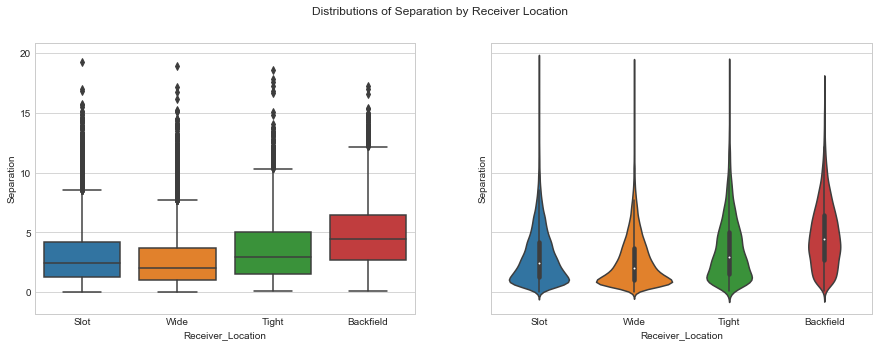

In [12]:
#Look at the distributions of Separation by Pre-Snap Receiver Location

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

fig.suptitle('Distributions of Separation by Receiver Location')
sns.boxplot(x="Receiver_Location", y="Separation", data=df, ax = ax1)
sns.violinplot(x="Receiver_Location", y="Separation", data=df, ax = ax2)

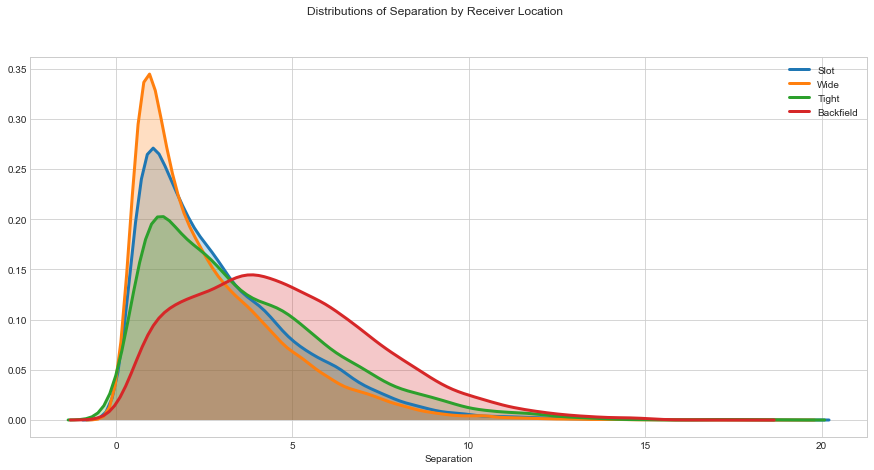

In [13]:
# List of four recevier locations to plot
RecLocations = list(df['Receiver_Location'].unique())

fig_dims = (15, 7)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Separation by Receiver Location')

# Iterate through the four receiver locations
for loc in RecLocations:
    # Subset to the Receiver location
    subset = df[df['Receiver_Location'] == loc]
    
    # Draw the density plots
    sns.distplot(subset['Separation'], ax = ax, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = loc)
    


In [14]:
print('The mean separation of Backfield targets is ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Separation'].mean(), 1)) + ' yards, +/- ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Separation'].std(), 1))+ ' yards')
print('The mean separation of NON-Backfield targets is ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Separation'].mean(), 1)) + ' yards, +/- ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Separation'].std(), 1))+ ' yards')

The mean separation of Backfield targets is 4.8 yards, +/- 2.7 yards
The mean separation of NON-Backfield targets is 2.9 yards, +/- 2.2 yards


### Backfield Targets

As we can see, Backfield targets have a **considerably higher** average separation and a distinctly different distribution from non-Backfield targets.

This makes sense, as receivers targeted in the backfield do not have pre-snap cushions, meaning that no one is lined up close to them at the time of snap. Since backfield targets have no one near them at the time of snap, receivers targeted in the backfield are often wide open at the time the pass arrives. This is because the defense either hasn't had enough time to get to the backfield to gaurd the player, or the player does not pose as big of a threat to the defense as the rest of the receivers, so the defense does not guard them as closely. 

Let's check this to see if our assumptions are correct - 

*Are targets to receivers in the backfield shorter (less air yards) and therefore warrant more separation?*



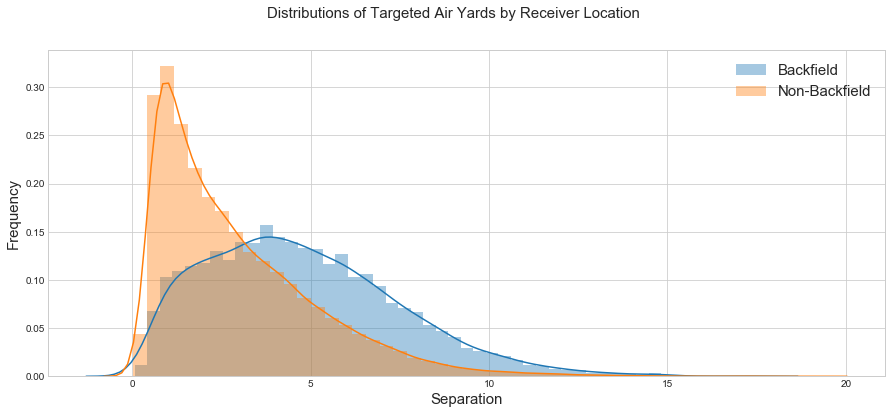

In [15]:
# List of Locations to compare
RecLocations = ['Backfield', 'Non-Backfield']

#Separate dataframes into Backfield and Non-Backfield Dataframes
Bkfd = df[df['Receiver_Location'] == 'Backfield']
NonBkfd = df[df['Receiver_Location'] != 'Backfield']

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Targeted Air Yards by Receiver Location', fontsize = 15)

# Iterate through the four receiver locations
for loc in RecLocations:
    # Subset to the Receiver location
    if loc == 'Backfield':
        subset = Bkfd
    else:
        subset = NonBkfd
    
    # Draw the density plots
    sns.distplot(subset['Separation'], ax = ax, label = loc)
    ax.legend(loc=1, prop={'size': 15})
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_xlabel('Separation', fontsize = 15)

In [16]:
print('Average Backfield Target: ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Air_Yds'].mean(), 2)) + ' yards downfield')
print('Average Non-Backfield Target: ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Air_Yds'].mean(), 2)) + ' yards downfield')

Average Backfield Target: 0.04 yards downfield
Average Non-Backfield Target: 10.06 yards downfield


### Dropping all rows for Targets in the Backfield

As we thought, backfield targets are markedly different from non-backfield targets, and exist almost exclusively 5 yards behind (or beyond) the line of scrimmage, while non-backfield targets occur downfield far more frequently. 


Since **all** of the cushion values are missing for targets to recievers who line up in the backfield, and they they usually are not indicative of anything the receiver is inherently doing to create separation, I am choosing to drop all rows targeting receivers who line up in the 'Backfield'

In [17]:
NB_Features = Features[Features['Receiver_Location'] != 'Backfield']
print(len(NB_Features))
missing_values_table(NB_Features)

43864
Your selected dataframe has 15 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Cushion,4279,9.8
Receiver_Location,108,0.2


## Drop all Missing Receiver Location Rows

Since the Missing Receiver_Locations represent ~0.2% of our data set, we can comfortably drop those offending rows.

In [18]:
NB_Features = NB_Features[NB_Features['Receiver_Location'].notnull()]
print(len(NB_Features))
missing_values_table(NB_Features)

43756
Your selected dataframe has 15 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Cushion,4190,9.6


We are left with 4190 misssing cushion values. 

These missing values, unlike the missing cushion values for 'Backfield' Targets, are *'missing at random'*. There is nothing in the dataset that would indicate that these cushions can be inferred from another feature, so I want to look into a way to impute these values effectively and efficiently. 

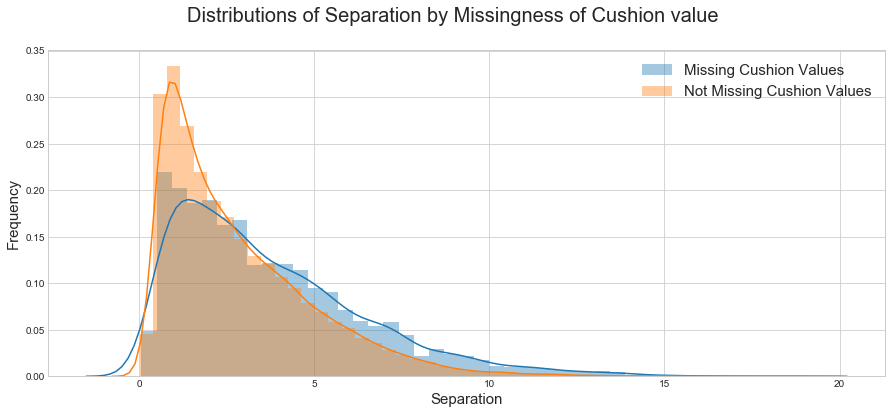

In [19]:
# List of two types of data to plot
DataTypes = ['Missing Cushion Values', 'Not Missing Cushion Values']

#Create dataframe with just non-Backfield targets
df_1 = df[df['Receiver_Location'] != 'Backfield']

#Separate dataframes into missing and non-missing Dataframes
M = df_1[df_1['Cushion'].isna()]
NM = df_1[df_1['Cushion'].notnull()]

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Separation by Missingness of Cushion value', fontsize = 20)

# Iterate through the two datatypes (missing and non-missing)
for loc in DataTypes:
    # Subset to the DataType
    if loc == 'Missing Cushion Values':
        subset = M
    else:
        subset = NM
    
    # Draw the density plots
    sns.distplot(subset['Separation'], ax = ax, label = loc)
    ax.legend(loc=1, prop={'size': 15})
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_xlabel('Separation', fontsize = 15)
    

In [20]:
print('Mean Separation w/ missing Cushion: ' + str(round(M['Separation'].mean(), 2)) + ' yards')
print('Mean Separation w/ non-missing Cushion: ' + str(round(NM['Separation'].mean(), 2)) + ' yards')

Mean Separation w/ missing Cushion: 3.72 yards
Mean Separation w/ non-missing Cushion: 2.81 yards


This makes intuitive sense, as we could imagine that targeting receviers who had no-one lined up across from them at the time of snap might lead to larger separation values. 

Let's look into this a little bit further to confirm our suspicions:

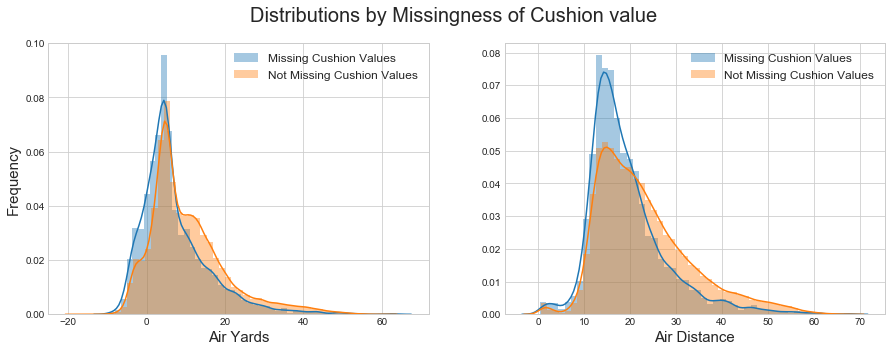

In [21]:
# List of two types of data to plot


fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Distributions by Missingness of Cushion value', fontsize=20)


# Iterate through the four receiver locations
for loc in DataTypes:
    # Subset to the DataType
    if loc == 'Missing Cushion Values':
        subset = M
    else:
        subset = NM
    
    # Draw the density plots
    sns.distplot(subset['Air_Yds'], ax = ax1, label = loc)
    sns.distplot(subset['Air_Dist'], ax = ax2, label = loc)

    ax1.legend(loc=1, prop={'size': 12})
    ax2.legend(loc=1, prop={'size': 12})
    ax1.set_xlabel('Air Yards', fontsize=15)
    ax2.set_xlabel('Air Distance', fontsize=15)
    ax1.set_ylabel('Frequency', fontsize=15)

In [22]:
Miss = np.array([round(M['Air_Yds'].mean(), 1), round(NM['Air_Yds'].mean(), 1)])
NotMiss = np.array([round(M['Air_Dist'].mean(), 1), round(NM['Air_Dist'].mean(), 1)])
MNS = np.array(['Missing Cushion', 'Not Missing Cushion'])
df_Missingness = pd.DataFrame(); df_Missingness['Avg Air Yards']=pd.Series(Miss) ;df_Missingness['Avg Air Distance']=pd.Series(NotMiss)
df_Missingness['Missingness']=pd.Series(MNS) ;df_Missingness.set_index('Missingness')

,Avg Air Yards,Avg Air Distance
Missingness,,
Missing Cushion,7.2,19.3
Not Missing Cushion,10.4,23.1


When players line up with no cushion, they often are targeted **closer to the line of scrimmage** (7.2 yards downfield vs 10.4) and **closer to where the pass was thrown** (19.3 yards as the crow flies vs. 23.1 yards) 

## Test to see if Distributions are statistically different from each other

We have suspicions that these two samples sets (rows with/without missing Cushion values) are statistically different, but let's confirm this in practice. In order to confirm that these two distributions are statistically different, I run a 2-sample Kolmogorov-Smirnov test [link](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)

If, in fact, they are different frmo each other, I must come up with a way to impute them that works to maintain each set's variance and distribution. If they are statistically the same, I can safely remove all offending rows.

In [23]:
from scipy.stats import ks_2samp

p_value = ks_2samp(M['Separation'], NM['Separation'])[1]

print('Our p-value for the K-S test to check for 2-sample similarity is ' + str(p_value))
print('Since our p-value < 0.05, we must find a way to deal with these values, we cannot remove them.')

Our p-value for the K-S test to check for 2-sample similarity is 4.951603139160891e-73
Since our p-value < 0.05, we must find a way to deal with these values, we cannot remove them.


### Methods of Imputation

1. Replace all missing Cushion values with a summary statistic (mean/median) of Cushion
    - **Pros**: Simple, understandable, and fast
    - **Cons**: Since we are replacing ~10% of our data, this will severely bias our distribution and negatively affect our train/validation accuracies
2. Single Imputation from Regression (kNN, Neural Networks)
    - **Pros**: Introduces less bias than mean/median imputation, is still relatively simple
    - **Cons**: Slower, still does not generate entries that accurately reflect the distribution of the underlying data
3. Multiple Imputation from Chained Equations (MICE)
    - **Pros**: Most accurate, creates multiple imputations and analyzes pool of possible choice to create imputation
    - **Cons**: Slowest and less simple than sinlge imputation
    
    
Due to the fact that I am looking to create the most accurate prediction of Separation possible, and am not too concerned with the comprehensability of how the imputed values were calculated, so long as they pass a few sanity checks. So I am choosing **MICE**. 

In [24]:
# Transform Categorical Features to One-Hot Encoded Binary Variables

NB_Features_encoded = pd.get_dummies(NB_Features)

NB_Features_encoded.head()


,Qtr,Down,To Go,Cushion,Air_Yds,Air_Dist,Air_Time,TTT,QB_Separation,QBP,...,Nearest_Def_Position_NT,Nearest_Def_Position_OLB,Nearest_Def_Position_S,Nearest_Def_Position_SAF,Nearest_Def_Position_SS,Nearest_Def_Position_TE,Nearest_Def_Position_WR,Receiver_Location_Slot,Receiver_Location_Tight,Receiver_Location_Wide
0,3,3,9,3.66,24.54,33.119846,1.539,2.756,2.084347,0,...,0,0,0,0,1,0,0,1,0,0
1,3,1,10,2.66,27.23,37.510450,2.202,2.436,1.540033,1,...,0,0,0,0,0,0,0,0,0,1
2,3,2,8,10.23,42.88,52.871040,2.633,3.135,3.386576,0,...,0,0,0,0,0,0,0,0,0,1
3,3,3,8,6.74,39.44,49.233444,3.018,2.771,2.814427,0,...,0,0,0,0,0,0,0,0,0,1
4,2,1,10,3.23,39.06,46.187710,2.636,3.003,1.471224,1,...,0,0,0,0,1,0,0,0,0,1


In [25]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer 
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

MICE_imputer = IterativeImputer(initial_strategy="median", max_iter = 1000, random_state = random_state)

NB_Features_enc_imp = MICE_imputer.fit_transform(NB_Features_encoded)

Cush_Fill = NB_Features_enc_imp[:,3]
NB_Features['Cushion'] = Cush_Fill

#Check how many null values there are
sum(NB_Features['Cushion'].isna())


0

In [26]:
Merged = NB_Features.copy()
Merged['Separation'] = Output

## Handling Outliers

Looking at the table below, I do not see many outrageous values that would warrant a deeper dive, except for the fact that the 'Air_Time' (time the pass has been launched to pass arrival) column has a minumum value of -0.167. Obviously, time cannot be negative, so I will drop all rows with negative time values. 




In [27]:
Merged.describe()

,Qtr,Down,To Go,Cushion,Air_Yds,Air_Dist,Air_Time,TTT,QB_Separation,QBP,Receiver_Dist_From_Sideline,QB_Speed_at_Pass,EZ_Dist,Separation
count,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000,43756.000000
mean,2.569796,1.950407,8.850809,5.865729,10.076165,22.743149,1.092692,2.676997,3.048941,0.205526,13.078713,3.323143,38.457193,2.899077
std,1.125045,0.848593,3.959485,2.828676,9.871677,10.121430,0.570437,0.976282,1.297303,0.404090,7.583627,3.248223,15.301920,2.231331
min,1.000000,1.000000,1.000000,0.910000,-17.550000,0.555428,-0.167000,0.299000,0.090554,0.000000,-5.466669,0.000000,-3.640000,0.020000
25%,2.000000,1.000000,6.000000,3.210000,3.700000,15.269947,0.697000,2.050000,2.150581,0.000000,6.280000,1.329546,28.910004,1.160657
50%,3.000000,2.000000,10.000000,5.830000,7.460000,20.458699,0.902000,2.536000,2.905056,0.000000,13.710000,2.147727,41.430000,2.278782
75%,4.000000,3.000000,10.000000,7.990000,14.620000,27.795274,1.320000,3.103000,3.752902,0.000000,19.243330,3.743182,50.739998,4.065145
max,5.000000,4.000000,40.000000,20.900000,63.520000,67.877680,4.586000,13.280000,13.840437,1.000000,26.663330,17.897728,60.000000,19.226980


In [28]:
Merged = Merged[Merged['Air_Time'] > 0]
print(len(Merged))
print('Looks like we dropped 6 rows with negative Air Time')

43750
Looks like we dropped 6 rows with negative Air Time


In [29]:
#Bring the Time Feature back, it was dropped earlier to create the imputations
Time_Index = Merged.index
Merged['Time'] = df['Time'][Time_Index]
#Merged.head()
Merged.columns

Index(['Nearest_Def_Position', 'Qtr', 'Down', 'To Go', 'Receiver_Location',
       'Cushion', 'Air_Yds', 'Air_Dist', 'Air_Time', 'TTT', 'QB_Separation',
       'QBP', 'Receiver_Dist_From_Sideline', 'QB_Speed_at_Pass', 'EZ_Dist',
       'Separation', 'Time'],
      dtype='object')

# Exploratory Data Analysis

Now the fun begins! We are left with 16 Raw Features and 1 Target Variable, as follows:

### Categories of Features
- **Numerical Variables**
    - *Discrete*
        1. Quarter - Done
        2. Down - Done
        3. Yards to Go - Done
    - *Binary*
        4. Was the QB Pressured? (Boolean) - Done
    - *Continuous*
        5. Pre-Snap Cushion - Done
        6. Air Yards - Done 
        7. Air Distance - Done
        8. Air Time 
        9. TTT (Time to Throw)
        10. QB Separation
        11. Receiver Distance from Sideline at Target
        12. QB Speed at Pass
        13. Distance Receiver is from Back of Endzone
- **Categorical**
    - *Non-Ordinal*
        14. Position of Nearest Defender
        15. Pre-Snap Receiver Location
- **Time Series Data**
    - *DateTime*
        16. Time left in Quarter
        
Lets create a quick correlation heatmap to see how linearly correlated these features are with Receiver Separation:
      

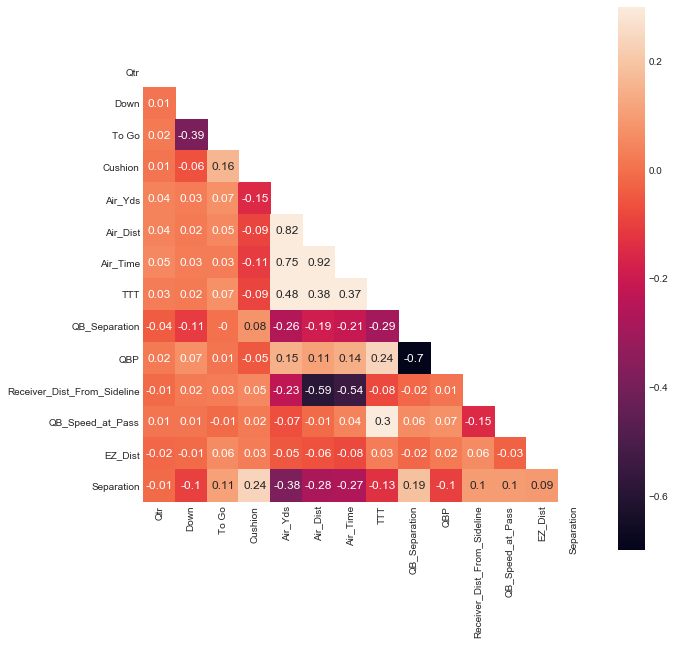

In [30]:
mask = np.zeros_like(Merged.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(round(Merged.corr(method = 'spearman'), 2), mask=mask, vmax=.3, square=True, annot=True, annot_kws={"size": 12})

## Feauture Analysis: Quarter

Text(0, 0.5, 'Separation')

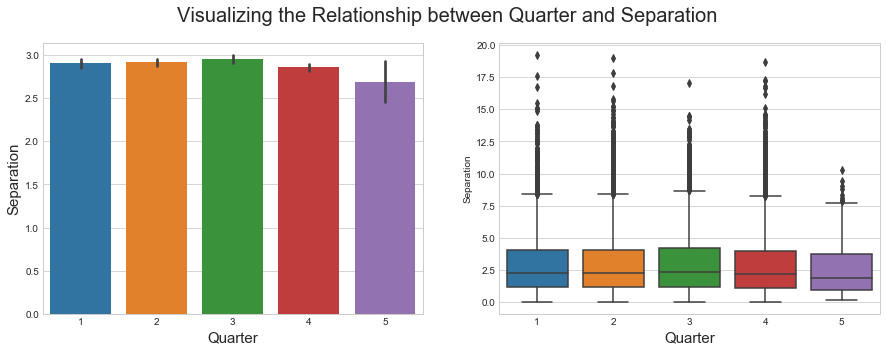

In [31]:
# Show some plots to visualize relationship beteen Quarter and Separation

fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Quarter and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='Qtr', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='Qtr', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Quarter', fontsize=15)
ax2.set_xlabel('Quarter', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)

In [32]:
Qtr_df = Merged[['Qtr', 'Separation']]
Qtr_df.groupby(['Qtr']).mean().round({'Separation': 2}).sort_values('Qtr', ascending = True)

,Separation
Qtr,
1,2.90
2,2.91
3,2.95
4,2.85
5,2.68


Just by looking at these distributions, I cannot tell whether quarter has any discernable affect on Separation, especially in the within a regulation game. It looks like passes in Overtime (the 5th quarter) have the lowest average separation, which makes sense, as the stakes are the highest. That said, before I decide to include/remove the feature, I want to run some t-tests to see if the distributions are statistically different from each other. In other words, is the fact that that 3rd quarter has the highest average separation significant? Or could this happen with any random subestting of data? 

## Feature Engineering - 'Is Overtime' 

I am going to separate all regulation Separations (quarters 1-4) with overtime (quarter 5) to see if theres anything there:

Text(0, 0.5, 'Separation')

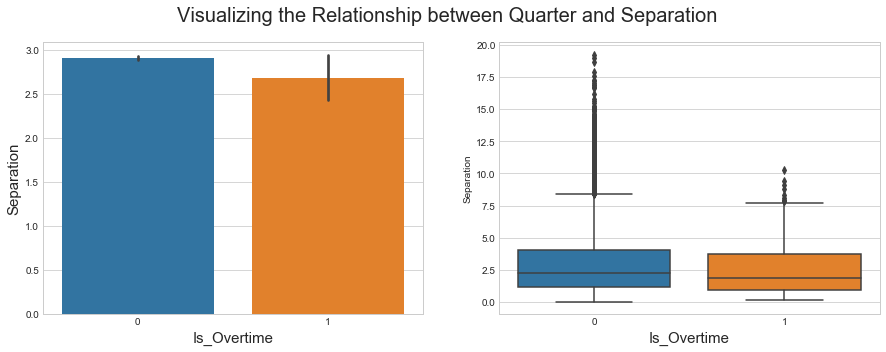

In [33]:
#Create new columns called 'Is_Overtime' that is 1 in overtime and 0 in all other quarter
Merged['Is_Overtime'] = 0
Merged.loc[Merged['Qtr'] == 5, 'Is_Overtime'] = 1

# Show some plots to visualize relationship beteen Quarter and Separation

fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Quarter and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='Is_Overtime', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='Is_Overtime', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Is_Overtime', fontsize=15)
ax2.set_xlabel('Is_Overtime', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)


In [34]:
rvs1 = Merged[Merged['Is_Overtime'] == 0]['Separation']
rvs2 = Merged[Merged['Is_Overtime'] == 1]['Separation']

p_value = round(stats.ttest_ind(rvs1,rvs2)[1], 5)

print('Our p value is ' + str(p_value))
print('Since our p value > 0.05, we cannot reject the null hypothesis, making the two disributions statistically similar.')

Our p value is 0.09982
Since our p value > 0.05, we cannot reject the null hypothesis, making the two disributions statistically similar.


Because of this, I will NOT include 'Is_Overtime in my modeling/features selection process.

# Feature Analysis: Down

Text(0, 0.5, 'Separation')

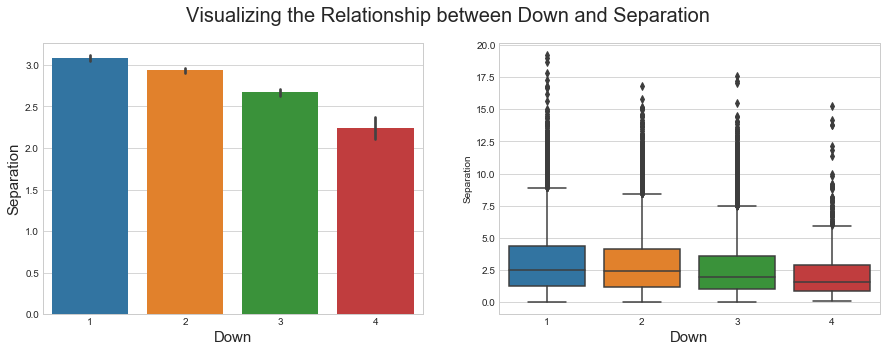

In [35]:
fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Down and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='Down', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='Down', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Down', fontsize=15)
ax2.set_xlabel('Down', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)

In [36]:
Down_df = Merged[['Down', 'Separation']]
Down_df.groupby(['Down']).mean().round({'Separation': 2}).sort_values('Down', ascending = True)

,Separation
Down,
1,3.08
2,2.93
3,2.67
4,2.24


There seems to be a correlation between what down it is and the separation of the targeted receiver. This isn't too surprising, as we would expect defenses to play more tightly in more high-stakes/important downs. 

Nothing more needs to be done here, we will keep Down in the data set and move on.

# Feature Analysis: Yards to Go

Text(0, 0.5, 'Separation')

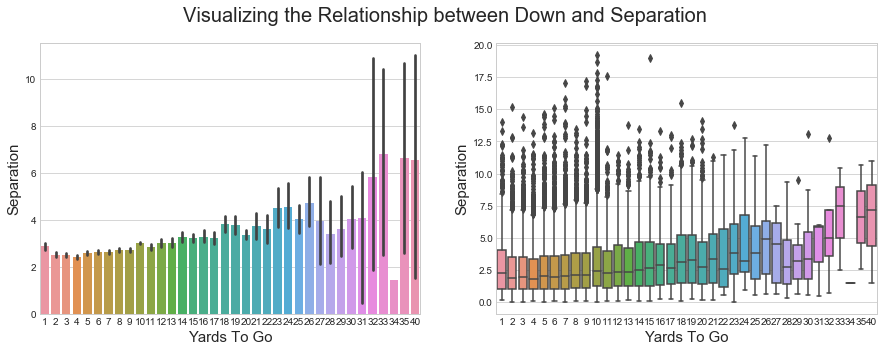

In [37]:
fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Down and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='To Go', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='To Go', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Yards To Go', fontsize=15)
ax2.set_xlabel('Yards To Go', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)
ax2.set_ylabel('Separation', fontsize=15)

As we saw above, the correlation coefficient of raw 'Yards To Go' to 'Separation' was 0.11. 

Instead of having 40 unqiue 'To Go' values, I am going to bin certain 'Yards To Go' values into a new category called 'YTG_Bin' or 'Yards To Go Binned.' There will be 4 categories - **Short** (1-4), **Medium** (5-9), **Long** (10), and **Longest** (10+) - in an effort to see if it helps create a higher correlations value or help in predictions. The value of 1 corresponds to Short, and 4 corresponds to Longest.

In [38]:
Merged['YTG_Bin'] = 0

def Create_YTG_Bins(row):
    #Short
    if row <= 4:
        return 'Short'
    
    #Medium
    elif (row >=5 and row <= 9):
        return 'Medium'
    
    #Long
    elif row == 10:
        return 'Long'
    
    #Anything over 10 Yards is Longest!
    elif row > 10:
        return 'Longest'
    
Merged['YTG_Bin'] = Merged['To Go'].apply(Create_YTG_Bins)

In [39]:
YTG_df = Merged[['YTG_Bin', 'Separation']]
YTG_df.groupby(['YTG_Bin']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)

,Separation
YTG_Bin,
Longest,3.26
Long,3.03
Medium,2.68
Short,2.56


# Feature Engineering: Down & Distance

Now that we have looked at 'Down' and 'Yards to Go' already, I want to combine them to create a 'Down & Distance' feature. Each of these features alone does not seem to have a lot predictive power, but combined, perhaps they will be more helpful. 

In [40]:
Merged['Down_Distance'] = ''
Merged['Down_Distance'] = Merged['Down'].astype(str) + '&' + Merged['YTG_Bin']
Merged.head()

,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Dist,Air_Time,TTT,QB_Separation,QBP,Receiver_Dist_From_Sideline,QB_Speed_at_Pass,EZ_Dist,Separation,Time,Is_Overtime,YTG_Bin,Down_Distance
0,SS,3,3,9,Slot,3.66,24.54,33.119846,1.539,2.756,2.084347,0,26.303329,1.145455,37.540001,1.785385,3:15,0,Medium,3&Medium
1,CB,3,1,10,Wide,2.66,27.23,37.510450,2.202,2.436,1.540033,1,12.303331,3.763636,40.230003,2.674790,10:47,0,Long,1&Long
2,CB,3,2,8,Wide,10.23,42.88,52.871040,2.633,3.135,3.386576,0,17.230000,1.247727,58.880001,3.966674,9:36,0,Medium,2&Medium
3,CB,3,3,8,Wide,6.74,39.44,49.233444,3.018,2.771,2.814427,0,19.433328,1.329546,56.439999,0.910220,6:45,0,Medium,3&Medium
4,SS,2,1,10,Wide,3.23,39.06,46.187710,2.636,3.003,1.471224,1,15.103330,3.477273,57.060001,1.676305,3:46,0,Long,1&Long


Text(0, 0.5, 'Separation')

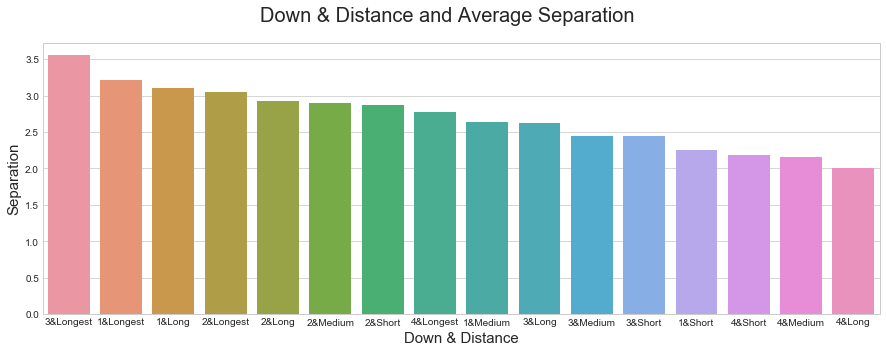

In [41]:
D_D_df = Merged[['Down_Distance', 'Separation']]
dddf = D_D_df.groupby(['Down_Distance']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False).reset_index()
dddf['Play_Counts'] = D_D_df.groupby(['Down_Distance']).count().round({'Separation': 2}).sort_values('Separation', ascending = False)

fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Down & Distance and Average Separation', fontsize=20)
sns.barplot(x='Down_Distance', y = 'Separation', data = dddf)

ax.set_xlabel('Down & Distance', fontsize=15)
ax.set_ylabel('Separation', fontsize=15)


# Feature Analysis: Was the QB Pressured?

Text(0, 0.5, 'Separation')

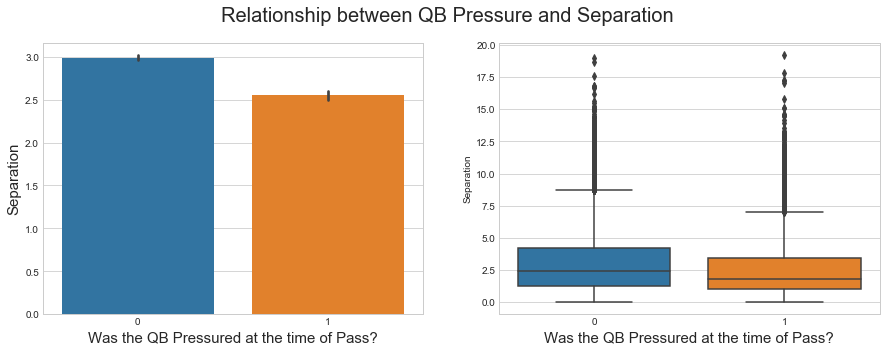

In [42]:
fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Relationship between QB Pressure and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='QBP', y='Separation', data=Merged, ax = ax1) 
sns.boxplot(x='QBP', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Was the QB Pressured at the time of Pass?', fontsize=15)
ax2.set_xlabel('Was the QB Pressured at the time of Pass?', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)

As we might expect, when the QB is pressured at the time of pass, receivers gain, on average, 0.5 yards of separation **LESS** than when the QB is kept clean at the time of throw. 

We can keep this feature an move on.

# Feature Analysis: Cushion

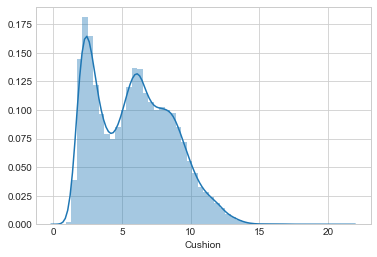

In [43]:
fig = sns.distplot(Merged['Cushion'])

I am noticing the **Bimodal** nature of this distribution, suggesting that players are usually either line up close to the receiver (think Press coverage) or far off of them (or 'Off' coverage). From this, I want to further look into how these two types of cushion relate to the recievers separation

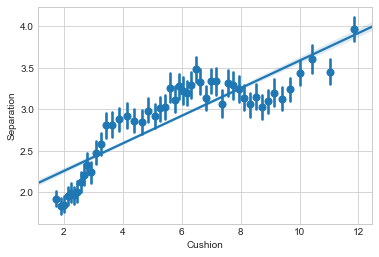

In [44]:
y = Merged['Separation']
x = Merged['Cushion']
p1 = sns.regplot(x=x, y=y, data=Merged, x_bins = 50)

# Feature Engineering: Press & Off Coverage

Seen in the binned scatter plot above, we can see that, on the whole, an increase in cushion leads (or at least is linearly correlated to) an increase in separation, up until about 3.5 yards of cushion. I will create a new feature called 'Press_Cushion' that is equal to 1 when they are 'pressed' at the line of scrimmage (< 3.5 yards) and 0 everywhere else.

In [45]:
Merged['Press_Cushion'] = 0
Merged['Press_Cushion'].loc[Merged['Cushion'] <= 3.5] = 1
Merged.head()

,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Dist,Air_Time,TTT,...,QBP,Receiver_Dist_From_Sideline,QB_Speed_at_Pass,EZ_Dist,Separation,Time,Is_Overtime,YTG_Bin,Down_Distance,Press_Cushion
0,SS,3,3,9,Slot,3.66,24.54,33.119846,1.539,2.756,...,0,26.303329,1.145455,37.540001,1.785385,3:15,0,Medium,3&Medium,0
1,CB,3,1,10,Wide,2.66,27.23,37.510450,2.202,2.436,...,1,12.303331,3.763636,40.230003,2.674790,10:47,0,Long,1&Long,1
2,CB,3,2,8,Wide,10.23,42.88,52.871040,2.633,3.135,...,0,17.230000,1.247727,58.880001,3.966674,9:36,0,Medium,2&Medium,0
3,CB,3,3,8,Wide,6.74,39.44,49.233444,3.018,2.771,...,0,19.433328,1.329546,56.439999,0.910220,6:45,0,Medium,3&Medium,0
4,SS,2,1,10,Wide,3.23,39.06,46.187710,2.636,3.003,...,1,15.103330,3.477273,57.060001,1.676305,3:46,0,Long,1&Long,1


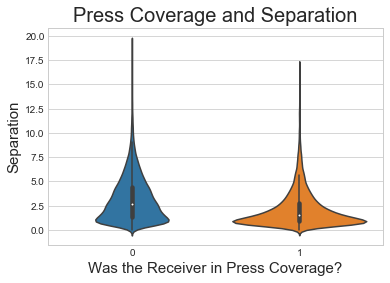

In [46]:
fig = sns.violinplot(x='Press_Cushion', y='Separation', data=Merged)
plt.title('Press Coverage and Separation', fontsize=20)

B=fig.set_xlabel('Was the Receiver in Press Coverage?', fontsize=15)
A=fig.set_ylabel('Separation', fontsize=15)

In [47]:
Pressed = Merged[['Press_Cushion', 'Separation']]
Pressed.groupby(['Press_Cushion']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)

,Separation
Press_Cushion,
0,3.20
1,2.14


Players who were pressed at the line of scrimmage (less than 3.5 yards of pre-snap cushion) saw **more than a yard of separation less** at pass arrival than receivers who were not pressed. 

Just to confirm, look at the overlayed distributions below to see how the distributions of receivers who are pressed behave differently to those who are not pressed ('Off coverage).

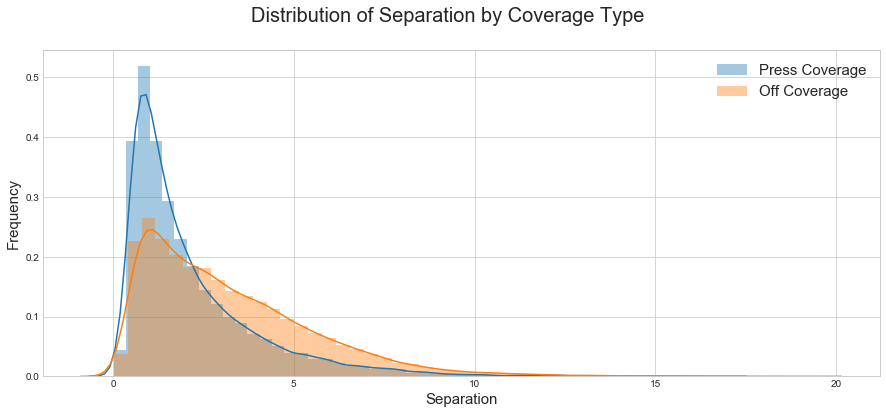

In [48]:
# List of two types of data to plot
DataTypes = ['Press Coverage', 'Off Coverage']

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distribution of Separation by Coverage Type', fontsize = 20)

# Iterate through the two datatypes (missing and non-missing)
for loc in DataTypes:
    # Subset to the DataType
    if loc == 'Press Coverage':
        subset = Merged['Separation'].loc[Merged['Press_Cushion'] ==1]
    else:
        subset = Merged['Separation'].loc[Merged['Press_Cushion'] ==0]
    
    # Draw the density plots
    sns.distplot(subset, ax = ax, label = loc)
    ax.legend(loc=1, prop={'size': 15})
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_xlabel('Separation', fontsize = 15)

# Feature Analysis: Air Distance

Air Distance is the straight line distance from where the ball is thrown to the where the ball is either caught, or the location of the targeted receiver

Text(0, 0.5, 'Separation')

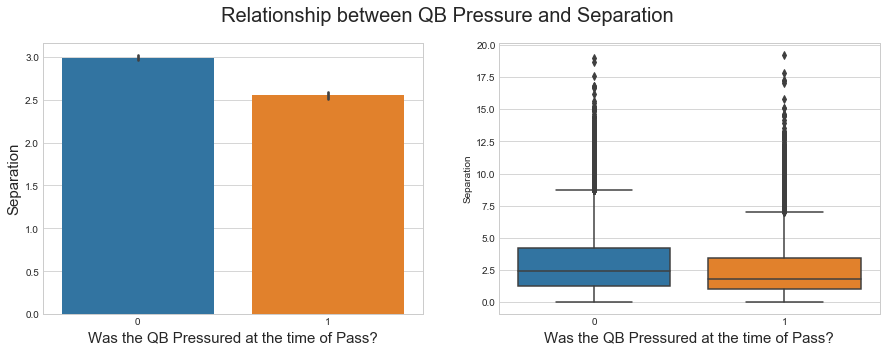

In [49]:

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Relationship between QB Pressure and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='QBP', y='Separation', data=Merged, ax = ax1) 
sns.boxplot(x='QBP', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Was the QB Pressured at the time of Pass?', fontsize=15)
ax2.set_xlabel('Was the QB Pressured at the time of Pass?', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)

Text(0.5, 0, 'Air Distance')

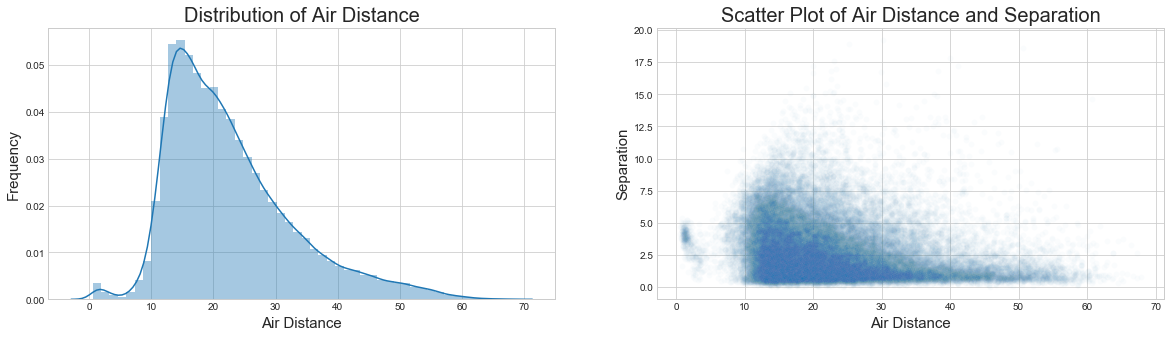

In [50]:
x = Merged['Air_Dist']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Air Distance', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Air Distance', fontsize = 15)

ax2.set_title('Scatter Plot of Air Distance and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
ax2.set_xlabel('Air Distance', fontsize = 15)

Text(0.5, 0, 'Air Distance')

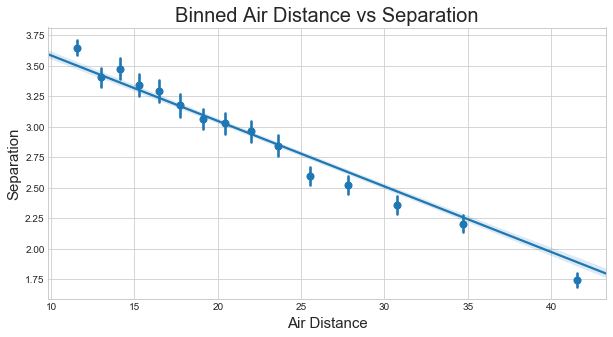

In [51]:
x = Merged['Air_Dist']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 15)

ax.set_title('Binned Air Distance vs Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
ax.set_xlabel('Air Distance', fontsize = 15)

In [52]:
x.corr(y)

-0.24321186349280385

# Feature Analysis: Air Yards

Air Yards are defined as the distance a pass is from the line of scrimmage, and can be negative if the pass is thrown to a reciever behind the line of scrimmage

Text(0.5, 0, 'Air Yards')

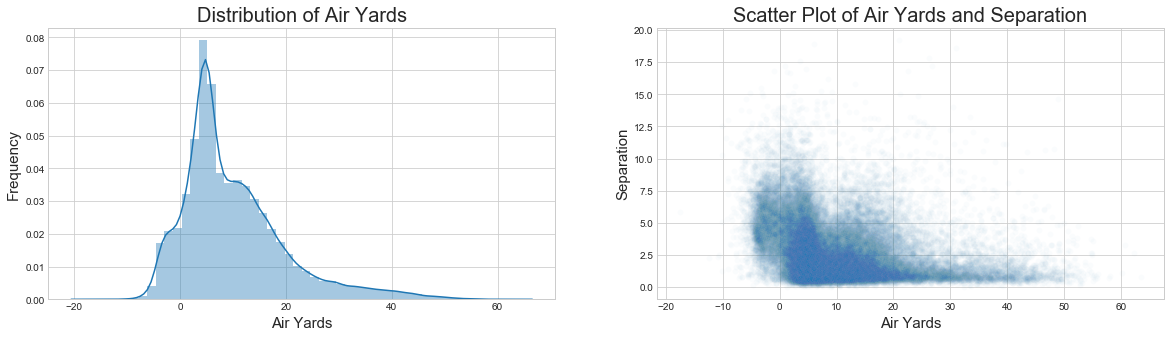

In [53]:
x = Merged['Air_Yds']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Air Yards', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Air Yards', fontsize = 15)

ax2.set_title('Scatter Plot of Air Yards and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
ax2.set_xlabel('Air Yards', fontsize = 15)

Text(0.5, 0, 'Air Yards')

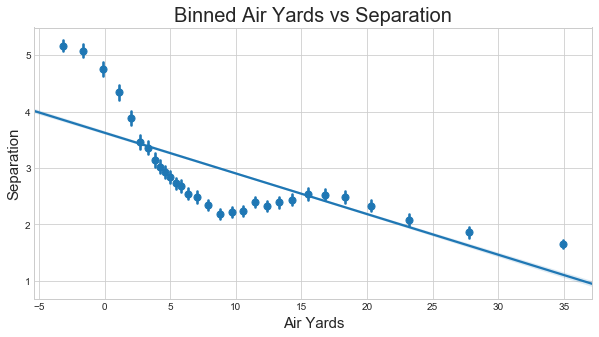

In [54]:
x = Merged['Air_Yds']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 30)

ax.set_title('Binned Air Yards vs Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
ax.set_xlabel('Air Yards', fontsize = 15)

It appears as though, unlike Air Distance, air yards doesn't correlate as linearly to Separation, and so I am going to focus on the portion of of the graph where Separation drops drastically. It looks like separation, on average, gets smaller as air yards get larger, but only until ~7 air yards. Let's make a new feature "Under 7 Air Yards' that is equal to air yards for all passes below 7 air yards, and 0 everywhere else

In [55]:
Merged['Below_7_AY'] = 0
Merged['Below_7_AY'].loc[Merged['Air_Yds'] <= 7] = Merged['Air_Yds']

Text(0.5, 0, 'Air Yards')

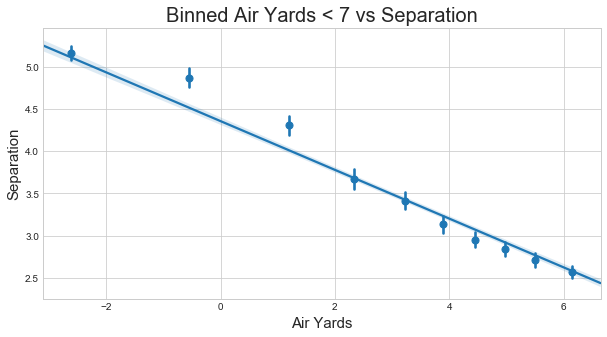

In [56]:
x = Merged['Below_7_AY'].loc[Merged['Below_7_AY'] != 0]
y = Merged['Separation'].loc[Merged['Below_7_AY'] != 0]

a = Merged['Air_Yds']
z = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 10)

ax.set_title('Binned Air Yards < 7 vs Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
ax.set_xlabel('Air Yards', fontsize = 15)

In [57]:
R = x.corr(y, method = 'pearson')
R1 = a.corr(z, method = 'pearson')
print(round(R1, 3));print(round(R, 3))

-0.318
-0.378


By isolating the instances where the air yards are below 7 yards, the pearson correlation value of jumped from **-0.318** for all plays to **-0.378** for all plays with air yards below 7 yards

# Feature Analysis: Air Time

Air Time\

What else do I mention here? Is there anything else I can join with Air time?

Text(0.5, 0, 'Air Time')

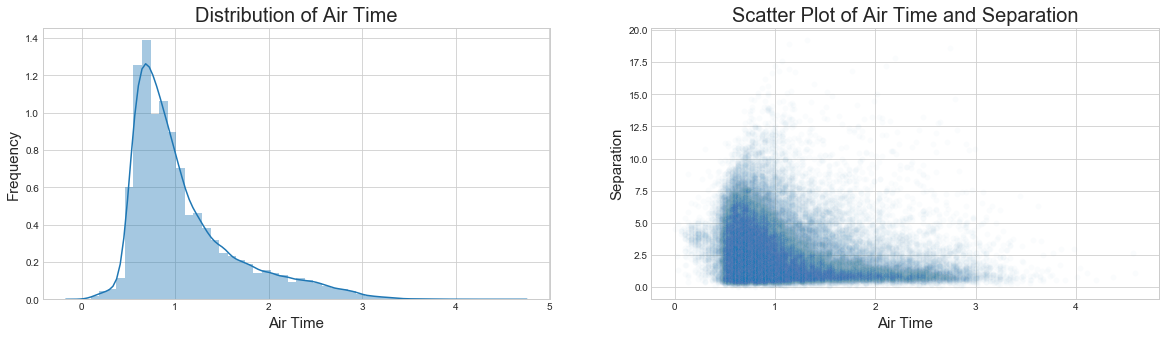

In [58]:
x = Merged['Air_Time']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Air Time', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Air Time', fontsize = 15)

ax2.set_title('Scatter Plot of Air Time and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
ax2.set_xlabel('Air Time', fontsize = 15)

In [59]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Air Time and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Air Time and Separation')

Spearman (rank) correlation: -0.273 between Air Time and Separation
Pearson (linear) correlation: -0.237 between Air Time and Separation


Should I do anything with this scatter plot? What is to be done about these correlation values?

# Feature Analysis: Time to Throw

Time to Throw is calculated as the time between the snap and the moment the QB releases the pass.

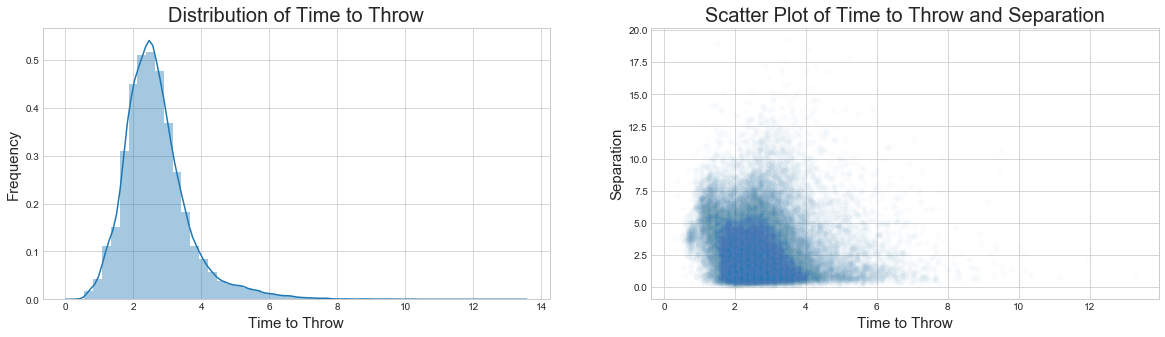

In [60]:
x = Merged['TTT']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Time to Throw', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Time to Throw', fontsize = 15)

ax2.set_title('Scatter Plot of Time to Throw and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Time to Throw', fontsize = 15)

In [61]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Time to Throw and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Time to Throw and Separation')

Spearman (rank) correlation: -0.125 between Time to Throw and Separation
Pearson (linear) correlation: -0.083 between Time to Throw and Separation


# Feature Engineering: Time to Throw & Air Time

As time to throw gets higher, separation goes down

In [62]:
Merged['TTT*AirTime']= Merged['Air_Time']*Merged['TTT']
Merged['TTT_plus_AirTime'] = Merged['Air_Time']+Merged['TTT']

x1 = Merged['TTT*AirTime']
x2 = Merged['TTT_plus_AirTime']

print('Spearman (rank) correlation: ' + str(round(x1.corr(y, method = 'spearman'), 3)) + ' between TTT*AirTime and Separation')
print('Spearman (rank) correlation: ' + str(round(x2.corr(y, method = 'spearman'), 3)) + ' between TTT_plus_AirTime and Separation')
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Time to Throw and Separation')

Spearman (rank) correlation: -0.272 between TTT*AirTime and Separation
Spearman (rank) correlation: -0.229 between TTT_plus_AirTime and Separation
Spearman (rank) correlation: -0.125 between Time to Throw and Separation


# Feature Analysis: QB Separation


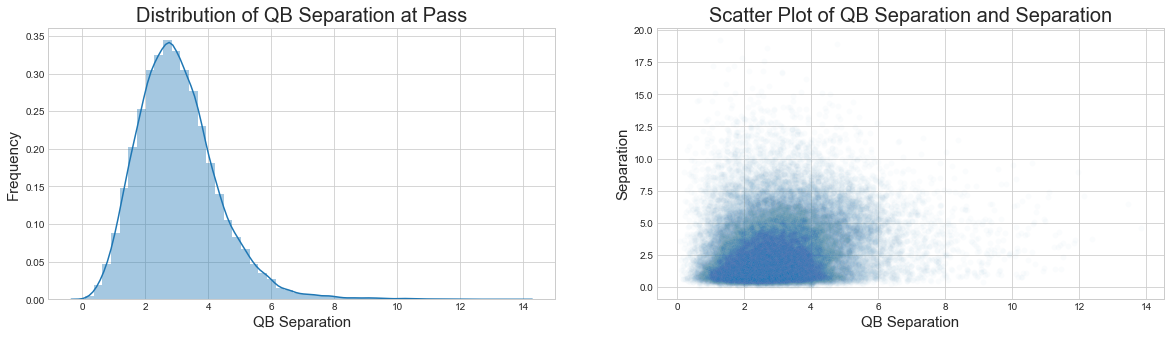

In [63]:
x = Merged['QB_Separation']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of QB Separation at Pass', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('QB Separation', fontsize = 15)

ax2.set_title('Scatter Plot of QB Separation and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('QB Separation', fontsize = 15)

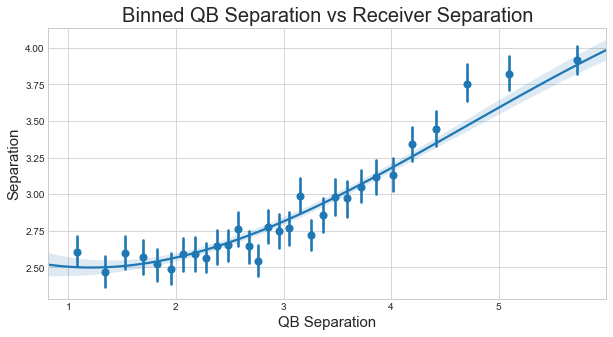

In [64]:
x = Merged['QB_Separation']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, order = 3, x_bins = 30)

ax.set_title('Binned QB Separation vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('QB Separation', fontsize = 15)

# Feature Analysis: Receiver Distance from Sideline as Pass Arrival

This feature quantifies the distance (in yards) from the targeted receiver and the nearest sideline at the time pass arrives. 

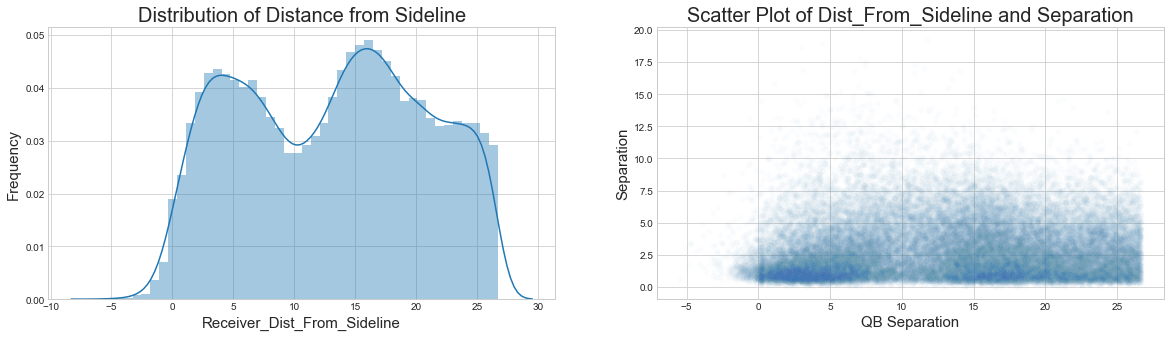

In [65]:
x = Merged['Receiver_Dist_From_Sideline']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Distance from Sideline', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Receiver_Dist_From_Sideline', fontsize = 15)

ax2.set_title('Scatter Plot of Dist_From_Sideline and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('QB Separation', fontsize = 15)

In the graph above, we see the distribution is bimodal, with values no greater than 26.66 (exactly at midfield) and going into the negatives. Negative values here indicate that the receiver was out of bounds by the time the pass arrived. 

In [66]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Time to Throw and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Time to Throw and Separation')

Spearman (rank) correlation: 0.101 between Time to Throw and Separation
Pearson (linear) correlation: 0.068 between Time to Throw and Separation


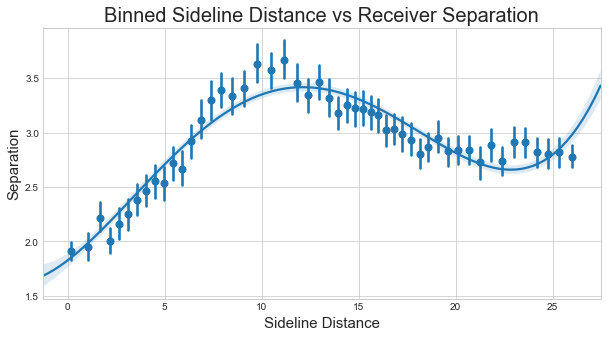

In [67]:
x = Merged['Receiver_Dist_From_Sideline']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, order = 4, x_bins = 50)

ax.set_title('Binned Sideline Distance vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Sideline Distance', fontsize = 15)

It appears as thought separation goes down steadily once the receiver gets 10 yards away from the sideline. I am going to create a new feature, called 'is_near_sideline' that is binary value (1 or 0) representing when the player is within 5 yards of the sideline to try and distinguish these types of situations.

# Feature Engineering: 'is_near_sideline'

In [68]:
Merged['is_near_sideline'] = 0
Merged['is_near_sideline'].loc[Merged['Receiver_Dist_From_Sideline'] <= 5] = 1
A = Merged['is_near_sideline'].sum()
B = len(Merged)
C = round(((A/B)*100), 1)
print(str(A) + ' of ' + str(B) + ' targets were within 5 yards of the sideline, or ' + str(C) + ' percent of all plays')

8653 of 43750 targets were within 5 yards of the sideline, or 19.8 percent of all plays


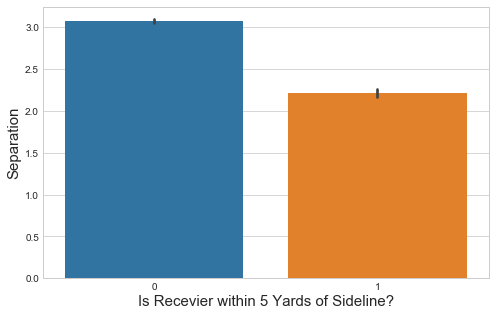

In [69]:
x = Merged['is_near_sideline']
y = Merged['Separation']
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x=x, y=y)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Is Recevier within 5 Yards of Sideline?', fontsize = 15)

# Feature Analysis: QB Speed at Pass Forward

This feature is defined as the speed (in miles per hour) of the QB when they release the ball at the moment of pass forward. 

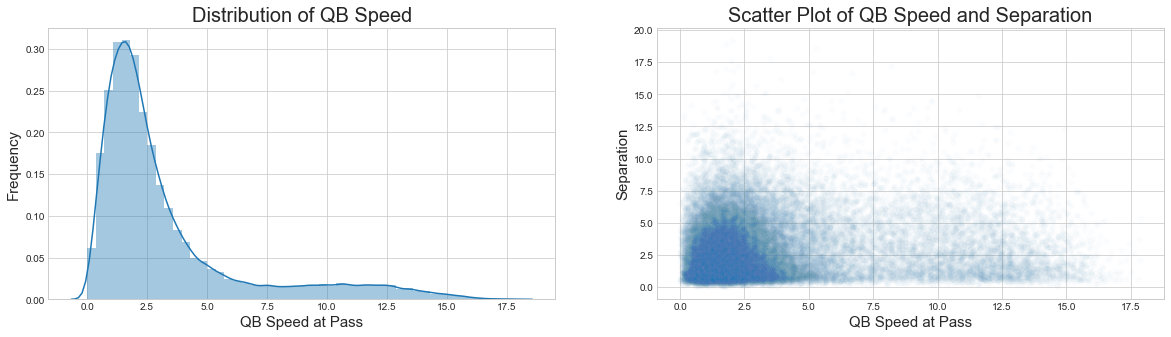

In [70]:
x = Merged['QB_Speed_at_Pass']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of QB Speed', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('QB Speed at Pass', fontsize = 15)

ax2.set_title('Scatter Plot of QB Speed and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('QB Speed at Pass', fontsize = 15)

In [71]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Time to Throw and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Time to Throw and Separation')

Spearman (rank) correlation: 0.102 between Time to Throw and Separation
Pearson (linear) correlation: 0.075 between Time to Throw and Separation


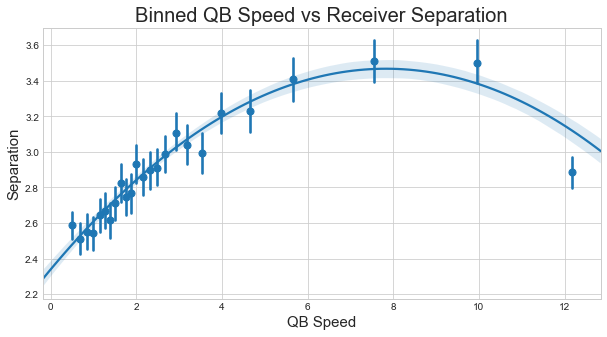

In [72]:
x = Merged['QB_Speed_at_Pass']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, order = 2,  x_bins = 25)

ax.set_title('Binned QB Speed vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('QB Speed', fontsize = 15)

I would expect that when a QB does not have their feet set (i.e. moving faster then 3 MPH), that they would be less accurate, and therefor have a lower separation, but this is the opposite of what is being shown in the grpah above. Perhaps it is becuase when a QB is on the run, they are no longer in one of their initial reads on the play, so the play is broken down most of the time, and they target the receiver who is most open. To this end, since I cannt say for certain what is happening within this variable, I do not think it will be helpful to dig in any further. 

# Feature Analysis: Distance Receiver is from Back of Endzone

This feature is defined as the distance (in yards) that there recevier is from the back of the endzone (in the direction the play is facing). 

My initial thought is that this feature will be noise until some yards within the back of the endzone, and then get lower as it endzone distance goes to 0. 

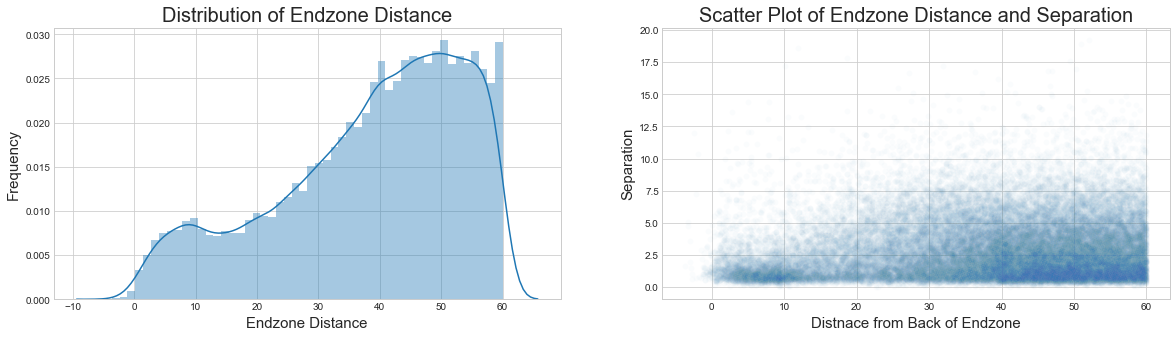

In [73]:
x = Merged['EZ_Dist']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Endzone Distance', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Endzone Distance', fontsize = 15)

ax2.set_title('Scatter Plot of Endzone Distance and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Distnace from Back of Endzone', fontsize = 15)

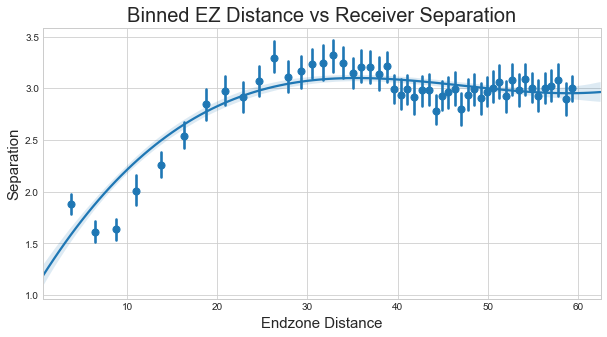

In [74]:
x = Merged['EZ_Dist']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, order = 3,  x_bins = 50)

ax.set_title('Binned EZ Distance vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Endzone Distance', fontsize = 15)

# Feature Engineering: Receiver Within 5 yard line?

Create binary value that is 1 when the target receiver is within 5 yards of the goalline (or 15 yards from the back of the endzone) and 0 everywhere else.

In [75]:
Merged['is_within_5'] = 0
Merged['is_within_5'].loc[Merged['EZ_Dist'] <= 15] = 1
A = Merged['is_within_5'].sum()
B = len(Merged)
C = round(((A/B)*100), 1)
print(str(A) + ' of ' + str(B) + ' targets were within 5 yards of the goal line, or ' + str(C) + '% of all plays')

4723 of 43750 targets were within 5 yards of the goal line, or 10.8% of all plays


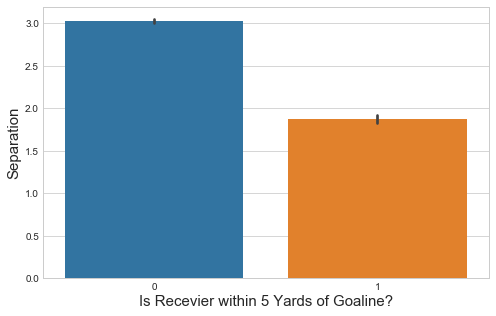

In [76]:
x = Merged['is_within_5']
y = Merged['Separation']
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x=x, y=y)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Is Recevier within 5 Yards of Goaline?', fontsize = 15)

# Categorical Features

## Position of Nearest Defender

In [77]:
Pos_df = Merged[['Nearest_Def_Position', 'Separation']]
Position = Pos_df.groupby(['Nearest_Def_Position']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)
Position['Play_Counts'] = Pos_df.groupby(['Nearest_Def_Position']).count()
Position

,Separation,Play_Counts
Nearest_Def_Position,,
DE,5.13,879
NT,5.13,115
DT,5.02,625
DL,4.50,17
OLB,3.69,3333
LB,3.66,1512
MLB,3.36,1519
ILB,3.34,2602
WR,3.01,18


It looks there are a lot of different positions listed here, but 23K plays belong just to CBs. I don't think there is much difference between positions like OLB and ILB, as well as DL vs DE vs DT. To this end, I will consolidate these categories to make it simpler to understand. Also, it looks like a few offensive skill players have been used on defense occasionally. Since they represent ~20 rows, I am going to drop them.

In [78]:
# Dropping all rows where skill position players that were the ones who were the nearest defender at pass arrival
skillpos = ['WR', 'TE', 'FB']
Merged = Merged[~Merged['Nearest_Def_Position'].isin(skillpos)]

## Feature Engineering: Clean up Defender Position Categories

In [79]:
LB = ['OLB', 'ILB', 'MLB', 'LB']
DL = ['DL', 'DE', 'DL', 'NT']
CB = ['CB', 'DB']
SAFE = ['SAF', 'S', 'FS', 'SS']

def NearestPos(row):
    
    #LBs
    if row in LB:
        return 'LB'
    
    #DLs
    elif row in DL:
        return 'DL'
    
    #CBs
    elif row in CB:
        return 'CB'
    
    #Safeties
    elif row in SAFE:
        return 'STY'
    

Merged['NDP_Consolidated'] = ''
Merged['NDP_Consolidated'] = Merged['Nearest_Def_Position'].copy().apply(NearestPos)    

In [80]:
NDP_df = Merged[['NDP_Consolidated', 'Separation']]
Pos = NDP_df.groupby(['NDP_Consolidated']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)
Pos['Play_Counts'] = NDP_df.groupby(['NDP_Consolidated']).count()
Pos

,Separation,Play_Counts
NDP_Consolidated,,
DL,5.12,1011
LB,3.53,8966
STY,2.90,8199
CB,2.53,24928


# Feature: Pre-Snap Receiver Location

This is what we covered a bit in earlier analysis, but this is broken down into 3 (previously 4, before _backfield_ was removed) categories:
- Wide
- Slot
- Tight

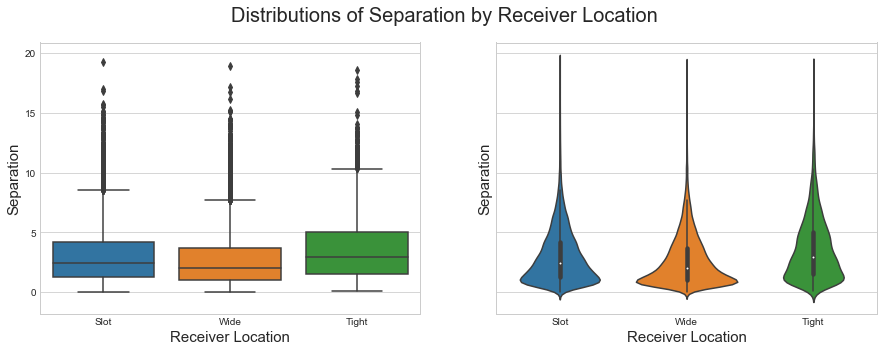

In [81]:
#Look at the distributions of Separation by Pre-Snap Receiver Location

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

fig.suptitle('Distributions of Separation by Receiver Location')
sns.boxplot(x="Receiver_Location", y="Separation", data=Merged, ax = ax1)
sns.violinplot(x="Receiver_Location", y="Separation", data=Merged, ax = ax2)

fig.suptitle('Distributions of Separation by Receiver Location', fontsize = 20)
ax1.set_ylabel('Separation', fontsize = 15)
ax1.set_xlabel('Receiver Location', fontsize = 15)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Receiver Location', fontsize = 15)

There are marginal differences between the distributions of these three locations, and I am going to leave them as-is. 

# Feature Analysis: Time

In [82]:
Merged['Time'].describe()

count     43728
unique      901
top       15:00
freq        907
Name: Time, dtype: object

There are 60 minutes in an NFL football game, and I don't think there is any inherent difference that we should expect when it comes to separation when its the start of the 1st, 2nd, 3rd, or 4th quarter. I think there might be more interesting things to find, but I want to translate this MM:SS time string that I am given to an integer value of seconds left in game, and go from there.

In [83]:
def time_to_seconds(time_str):
    #Change the string 'Time' to a value in seconds
    
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

#Quick check to make sure this function does what I am intending
print(str(Merged['Time'][3]) + ' is equal to ' + str(time_to_seconds(Merged['Time'][3])) + ' seconds')
print(str(Merged['Time'][50]) + ' is equal to ' + str(time_to_seconds(Merged['Time'][50])) + ' seconds')
print(str(Merged['Time'][300]) + ' is equal to ' + str(time_to_seconds(Merged['Time'][300])) + ' seconds')

6:45 is equal to 405 seconds
10:29 is equal to 629 seconds
1:18 is equal to 78 seconds


I found a bug with the function, because it didn't know how to treat 'nan' Time values. These were not found earlier because they are 'non as strings, not the Nans that pandas recognizes. Let's remove them now

In [90]:
Merged['Time'] = Merged['Time'].astype(str)
Merged = Merged[Merged['Time'] != 'nan']

In [91]:
Merged['Time_in_Sec'] = Merged['Time'].apply(time_to_seconds)

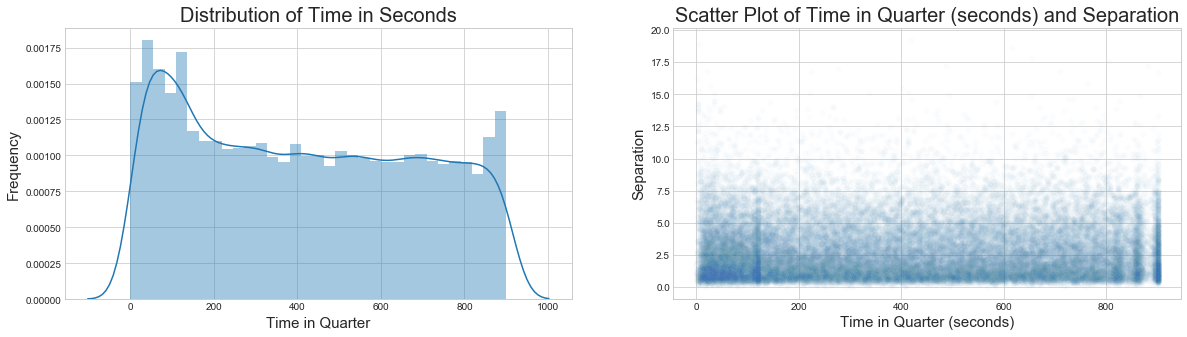

In [92]:
x = Merged['Time_in_Sec']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Time in Seconds', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Time in Quarter', fontsize = 15)

ax2.set_title('Scatter Plot of Time in Quarter (seconds) and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Time in Quarter (seconds)', fontsize = 15)

In [93]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Time and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Time and Separation')

Spearman (rank) correlation: 0.021 between Time and Separation
Pearson (linear) correlation: 0.015 between Time and Separation


As you might've guessed, the time left in a quarter has almost no correlation to the separation. 

Let's do some feature engineering to see if we can get some more insight out of this feature.

# Feature Engineering: Time Left in Game/Time Left in Half

Its not enough to use just the time left in the quarter to understand how time left affects gameplay, especially receiver separation. Let's see if include Quarter into this measurement helps us understand more.

In [94]:
Merged['sec_left_in_game'] = Merged['Time_in_Sec'] + ((4-Merged['Qtr'])*15*60)


#Check to see that this is doing what we are expecting

print(str(Merged['Time'][3]) + ' in the ' + str(Merged['Qtr'][3]) + 'rd Quarter is equal to ' + str(Merged['sec_left_in_game'][3]) + ' seconds')
print(str(Merged['Time'][30]) + ' in the ' + str(Merged['Qtr'][30]) + 'th Quarter is equal to ' + str(Merged['sec_left_in_game'][30]) + ' seconds')
print(str(Merged['Time'][400]) + ' in the ' + str(Merged['Qtr'][400]) + 'st Quarter is equal to ' + str(Merged['sec_left_in_game'][400]) + ' seconds')

6:45 in the 3rd Quarter is equal to 1305 seconds
7:24 in the 4th Quarter is equal to 444 seconds
4:12 in the 1st Quarter is equal to 2952 seconds


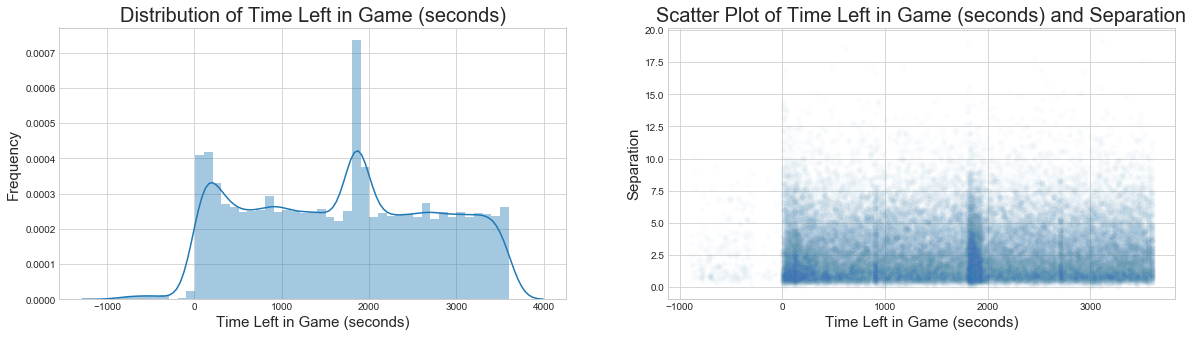

In [95]:
x = Merged['sec_left_in_game']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Time Left in Game (seconds)', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Time Left in Game (seconds)', fontsize = 15)

ax2.set_title('Scatter Plot of Time Left in Game (seconds) and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Time Left in Game (seconds)', fontsize = 15)

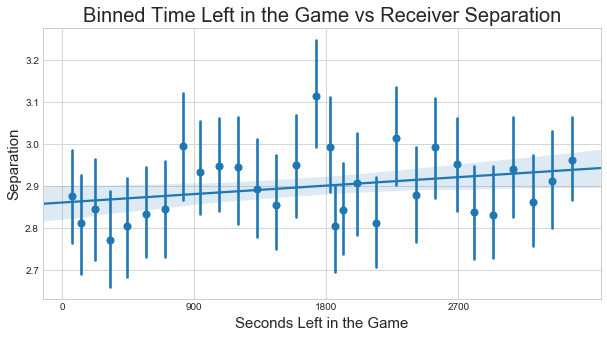

In [145]:
x = Merged['sec_left_in_game']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 30)

ax.set_title('Binned Time Left in the Game vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
plt.xticks(np.arange(0, 3600, step=900))
A = ax.set_xlabel('Seconds Left in the Game', fontsize = 15)

I cannot see any strong trends from the graph above, so let me take this a step further, by isolating time by halves.

## Feature Engineering: Time Left in Half

I would like to see if theres anything to the fact that 2 minute scenarios (ends of each half) might be more telling. I suspect that creating a new field called **_'time left in half'_** might be more insightful

In [120]:
mask = (Merged['Qtr'] == 1) | (Merged['Qtr'] == 3)
Merged['sec_left_in_half'] = Merged['Time_in_Sec']
Merged['sec_left_in_half'][mask] = Merged['Time_in_Sec'] + 900
Merged.head() 

,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Dist,Air_Time,TTT,...,Press_Cushion,Below_7_AY,TTT*AirTime,TTT_plus_AirTime,is_near_sideline,is_within_5,NDP_Consolidated,Time_in_Sec,sec_left_in_game,sec_left_in_half
0,SS,3,3,9,Slot,3.66,24.54,33.119846,1.539,2.756,...,0,0.0,4.241484,4.295,0,0,STY,195,1095,1095
1,CB,3,1,10,Wide,2.66,27.23,37.510450,2.202,2.436,...,1,0.0,5.364072,4.638,0,0,CB,647,1547,1547
2,CB,3,2,8,Wide,10.23,42.88,52.871040,2.633,3.135,...,0,0.0,8.254455,5.768,0,0,CB,576,1476,1476
3,CB,3,3,8,Wide,6.74,39.44,49.233444,3.018,2.771,...,0,0.0,8.362878,5.789,0,0,CB,405,1305,1305
4,SS,2,1,10,Wide,3.23,39.06,46.187710,2.636,3.003,...,1,0.0,7.915908,5.639,0,0,STY,226,2026,226


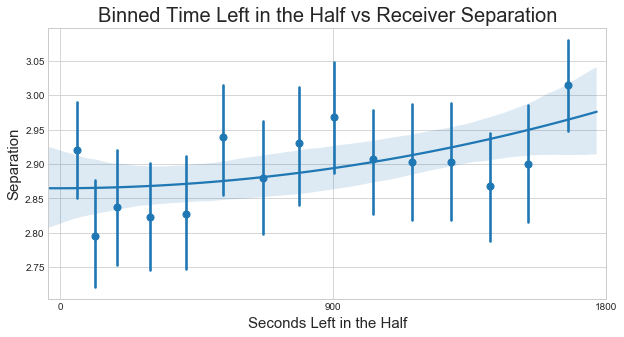

In [135]:
x = Merged['sec_left_in_half']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, order = 2,  x_bins = 15)

ax.set_title('Binned Time Left in the Half vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
plt.xticks(np.arange(0, 2700, step=900))
A = ax.set_xlabel('Seconds Left in the Half', fontsize = 15)

In [136]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Time and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Time and Separation')

Spearman (rank) correlation: 0.023 between Time and Separation
Pearson (linear) correlation: 0.015 between Time and Separation


Turns out, this had little to **no effect** on my correlation values, but so it goes! I am going to try one more thing to see if it is potentially helpful. I am going to create a boolean for 'is_under_2_min' that checks whether the play comes with under 2 minuets left in the half.

## Feature Engineering: 2-Minute Drill? 

Does the pass come with under 2 minutes left in a half?

In [139]:
Merged['Under_2Min'] = 0
Merged['Under_2Min'].loc[Merged['sec_left_in_half'] <= 120] = 1

A = Merged['Under_2Min'].sum()
B = len(Merged)
C = round(((A/B)*100), 1)
print(str(A) + ' of ' + str(B) + ' targets came with under 2 min remaining in the half, or ' + str(C) + '% of all plays')

6306 of 43728 targets came with under 2 min remaining in the half, or 14.4% of all plays


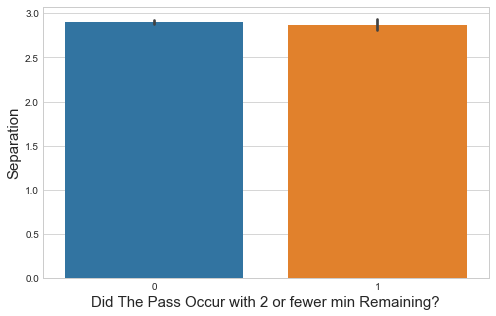

In [141]:
x = Merged['Under_2Min']
y = Merged['Separation']
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x=x, y=y)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Did The Pass Occur with 2 or fewer min Remaining?', fontsize = 15)

As we can see, being under 2 min left in the half as almost no effect on receiver separation, and I can potentially draw the conclusion that the time in the game has virtually no relation to the receiver separation on any given play. 

### 

Question for Jake/Alamo/Anyone in ML. 

Why don't I just create a dataframe with the feature interactions (x, +, -, /) between every feature and compare correlation values accross all features?
